<a href="https://colab.research.google.com/github/richardcsuwandi/data-structures-and-algorithms/blob/master/Artificial%20Neural%20Network%20on%20Bank%20Customers%20Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Neural Network on Bank Customers Dataset

This project is one of my Deep Learning projects. For this project, we have a [bank customers](https://github.com/richardcsuwandi/datasets/blob/master/bank_customers.csv) dataset that consists of a randomly sampled population of a banking customers detailing demographics and whether a customer left (or stayed at) the bank within the last 6 months.

The goal of this project is create an Artificial Neural Network (ANN) model to classifiy whether a customer will stay or leave from the bank.

In [1]:
# Import the libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading the Data
First, we need to load the data from the `bank_customers.csv` file and convert it into a Pandas DataFrame.

In [2]:
# Import the data
path = 'https://raw.githubusercontent.com/richardcsuwandi/datasets/master/bank_customers.csv'
data_raw = pd.read_csv(path)

# View the first 5 observations of the data
data_raw.head()

RowNumber  CustomerId   Surname  ...  IsActiveMember EstimatedSalary Exited
0          1    15634602  Hargrave  ...               1       101348.88      1
1          2    15647311      Hill  ...               1       112542.58      0
2          3    15619304      Onio  ...               0       113931.57      1
3          4    15701354      Boni  ...               0        93826.63      0
4          5    15737888  Mitchell  ...               1        79084.10      0

[5 rows x 14 columns]

In [3]:
# View a more detailed summary of the data
data_raw.describe(include='all')

RowNumber    CustomerId  ... EstimatedSalary        Exited
count   10000.00000  1.000000e+04  ...    10000.000000  10000.000000
unique          NaN           NaN  ...             NaN           NaN
top             NaN           NaN  ...             NaN           NaN
freq            NaN           NaN  ...             NaN           NaN
mean     5000.50000  1.569094e+07  ...   100090.239881      0.203700
std      2886.89568  7.193619e+04  ...    57510.492818      0.402769
min         1.00000  1.556570e+07  ...       11.580000      0.000000
25%      2500.75000  1.562853e+07  ...    51002.110000      0.000000
50%      5000.50000  1.569074e+07  ...   100193.915000      0.000000
75%      7500.25000  1.575323e+07  ...   149388.247500      0.000000
max     10000.00000  1.581569e+07  ...   199992.480000      1.000000

[11 rows x 14 columns]

## Preprocessing the Data
As we can see above, we don't have any missing values in our data. However, there are some columns that might not be useful for building our model e.g `RowNumber`, `CustomerId`, and `Surname`.

In [4]:
# Drop the 'RowNumber', 'CustomerId', and 'Surname' columns
data = data_raw.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data.head()

CreditScore Geography  Gender  ...  IsActiveMember  EstimatedSalary  Exited
0          619    France  Female  ...               1        101348.88       1
1          608     Spain  Female  ...               1        112542.58       0
2          502    France  Female  ...               0        113931.57       1
3          699    France  Female  ...               0         93826.63       0
4          850     Spain  Female  ...               1         79084.10       0

[5 rows x 11 columns]

Next, we can declare the features and label in our dataset. Here, our label (column to predict) is the `Exited` column which contains either 0 (left) or 1 (stayed). All the other columns will be our features.

In [5]:
# Declare the features and labels
X = data.drop('Exited', axis=1)  # Features
y = data['Exited']  # Label

Now, let's take a look at our features (X) and determine whether we need to further preprocess it or not.

In [6]:
X.head()

CreditScore Geography  Gender  ...  HasCrCard  IsActiveMember  EstimatedSalary
0          619    France  Female  ...          1               1        101348.88
1          608     Spain  Female  ...          0               1        112542.58
2          502    France  Female  ...          1               0        113931.57
3          699    France  Female  ...          0               0         93826.63
4          850     Spain  Female  ...          1               1         79084.10

[5 rows x 10 columns]

We notice that we have two columns that contain categorical values: `Geography` and `Gender`. So, we are going to create dummy variables to need to convert those categorical values into numerical values.

In [7]:
# Create dummy variables
geo = pd.get_dummies(X['Geography'], drop_first=True)
gender = pd.get_dummies(X['Gender'], drop_first=True)

# Concatenate the dummy columns
X = pd.concat([X, geo, gender], axis=1)

# Drop the columns that are no longer required
X = X.drop(['Geography', 'Gender'], axis=1)
X.head()

CreditScore  Age  Tenure    Balance  ...  EstimatedSalary  Germany  Spain  Male
0          619   42       2       0.00  ...        101348.88        0      0     0
1          608   41       1   83807.86  ...        112542.58        0      1     0
2          502   42       8  159660.80  ...        113931.57        0      0     0
3          699   39       1       0.00  ...         93826.63        0      0     0
4          850   43       2  125510.82  ...         79084.10        0      1     0

[5 rows x 11 columns]

Now, we can split our data into training and test sets. Following the Pareto principle, we are going to split the data with a ratio of 80:20.

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

One last step is we need to do feature scaling on our data before building our model. To avoid any data leakage, we will fit the scaler on our training set only, then standardise the test set with that scaler.

In [9]:
# Scale our data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Building our Model
After cleaning and preprocessing our data, we are now ready to build our ANN model. Our data will consist of 2 dense (fully-connected) layers with ReLu activation functions and another 1 dense layer as our output layer with Sigmoid activation function.

In [10]:
# Build the model
model = Sequential()
model.add(Dense(input_dim=11, units=6, activation='relu'))
model.add(Dense(units=6, activation='relu', name='hid'))
model.add(Dense(units=1, activation='sigmoid'))

In [11]:
# Get the architecture of our model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
hid (Dense)                  (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


Before training the model, we need to compile the model with the following settings:

- Loss function: This measures how accurate the model is during training. For the loss function, we are going to use the binary cross entropy.
- Optimizer: This is how the model is updated based on the data it sees and its loss function. We are going to use Adam, which is an optimization algorithm based on adaptive estimation of first-order and second-order moments.
- Metrics: Used to monitor the training and testing steps. Here we will use accuracy, the fraction of the images that are correctly classified.

In [12]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Finally, we can fit the training set to our model.

In [13]:
# Fit the model
history = model.fit(X_train, y_train, batch_size=10, epochs=100)

Epoch 1/100
8000/8000 [==============================] - 1s 126us/step - loss: 0.5324 - accuracy: 0.7843
Epoch 2/100
8000/8000 [==============================] - 1s 111us/step - loss: 0.4420 - accuracy: 0.8105
Epoch 3/100
8000/8000 [==============================] - 1s 111us/step - loss: 0.4269 - accuracy: 0.8167
Epoch 4/100
8000/8000 [==============================] - 1s 111us/step - loss: 0.4220 - accuracy: 0.8198
Epoch 5/100
8000/8000 [==============================] - 1s 113us/step - loss: 0.4184 - accuracy: 0.8224
Epoch 6/100
8000/8000 [==============================] - 1s 110us/step - loss: 0.4152 - accuracy: 0.8270
Epoch 7/100
8000/8000 [==============================] - 1s 109us/step - loss: 0.4125 - accuracy: 0.8261
Epoch 8/100
8000/8000 [==============================] - 1s 107us/step - loss: 0.4113 - accuracy: 0.8304
Epoch 9/100
8000/8000 [==============================] - 1s 120us/step - loss: 0.4095 - accuracy: 0.8299
Epoch 10/100
8000/8000 [==============================]

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.86 (or 86%) on the training set. We can also visualize the plot for the loss for each epoch.

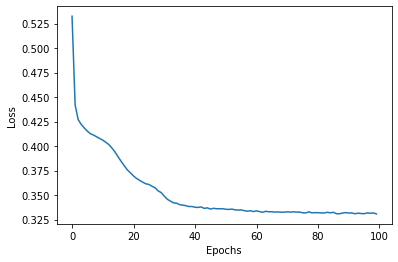

In [14]:
# Visualize the loss for each epoch
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

With the model trained, we can now use it to make predictions.

In [15]:
# Make predictions
y_pred = model.predict(X_test)

# Convert into Boolean values
y_pred = y_pred > 0.5

## Evaluating the Model
Lastly, let's evaluate our model on the test set.


In [16]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'The loss on the test set is: {test_loss}')
print(f'The accuracy on the test set is: {test_acc}')

2000/2000 [==============================] - 0s 25us/step
The loss on the test set is: 0.3315143666267395
The accuracy on the test set is: 0.8640000224113464


It turns out that the accuracy on the test dataset is a slightly higher than the accuracy on the training data. As another evaluation metric, we can create a confusion matrix to further examine our model's performace.

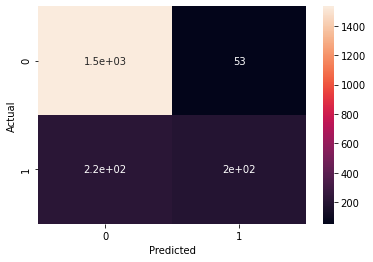

In [17]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

We can observe that our model is pretty good at classifying 0 values (customers leaving the bank) but not that good in the case where the values are 1 (customers that are actually staying). This is probably due to the imbalance amount of label in our data where our data contains a lot more 0 values than the 1 values.